# Análisis de similitud de modelos Intra-Complejo

Autor: Luis García Aguirre

Queremos comprobar si hay diferencias significativas entre los modelos de los complejos del "*dataset 22*" entre el cristal de SKEMPI y los ensamblados biológicos de **RCSB PDB**; y entre ellos en caso de haber más de uno.  

Para este fin, se calculará el **CAPRI RMSD** de todos los complejos entre sí, que es una métrica utilizada en CAPRI (*Critical Assessment of Predicted Interactions*) para la evaluación de predicciones estructurales. Es decir, es una métrica para poderar la diferencia entre dos estructuras que tiene en cuenta el **i-RMSD** (RMSD de los residuos en la interfaz), el **l-RMS** (RMSD del ligando tras superposición del receptor) y el **fnat** (fracción de contactos nativos recuperados).  

El programa que se utilizará para este cálculo es **PyDock**, en su versión 3 o 4, en local.

El modo de ejecutar PyDock es concreto. Para utilizar PyDock necesitamos una carpeta donde se encuentre un archivo `.ini` y los `.pdb`s con los que trabajará. Para correrlo necesitamos dar el nombre del archivo `.ini` sin la extensión; éste es el *docking_name* de la sintaxis general de PyDock. 

> alias pydock3=PATH/WHERE/PYDOCK_BIN/pyDock3    
> pydock3 docking_name moduleNAME

Ver: https://life.bsc.es/pid/pydock/doc/tutorial.html.

Ya que vamos a realizar un análisis entre modelos de un mismo complejo y tenemos varios complejos, creo una carpeta para cada complejo donde tener los archivos pertinentes para correr el análisis y guardar los archivos de salida propios de cada uno. Parto de un archivo .txt que contiene una lista de los complejos:

In [4]:
with open('pdb_list.txt', 'r') as f:
    texto = f.readlines()
    print(texto)

['1A22\n', '1BP3\n', '1C1Y\n', '1E50\n', '1GUA\n', '1K8R\n', '1KNE\n', '1LFD\n', '2FTL\n', '3EQS\n', '3EQY\n', '3M62\n', '3M63\n', '3MZG\n', '3Q8D\n', '3S9D\n', '4BFI\n', '4G0N\n', '4OFY\n', '4RS1\n', '5F4E\n', '5M2O\n']


In [5]:
# mkdir $(cat pdb_list.txt | tr '\n' ' ')

Una vez se han creado las carpetas, descargamos los ensamblajes biológicos de RCSB con un [script de bash](obtener_pdbs_biological_assemblies.sh) usando APIs: "*obtener_pdbs_biological_assemblies.sh*".

In [6]:
# ./obtener_pdbs_biological_assemblies.sh pdb_list.txt

Los cristales de SKEMPI los descomprimí de [cristales_AF3_22.zip](cristales_AF3_22.zip) y los moví a sus carpetas correspondientes de manera programática con otro breve [script de bash](cristal_a_dir.sh): "*cristal_a_dir.sh*".

In [7]:
# unzip cristales_AF3_22.zip
# ./cristal_a_dir.sh cristales_AF3_22

Una vez tuve los `.pdb` de los cristales de SKEMPI junto con los ensamblajes biológicos de RSCB de cada complejo en sus carpetas, hice una copia de todos ellos en una carpeta llamada `raw_complexes_pre_INI` que usé para sustituir las carpetas cuando salía algo mal durante la creación de los `.ini` y los análisis. El archivo comprimido de esta carpeta es: [raw_complexes_pre_INI.zip](raw_complexes_pre_INI.zip).  

Si este script es reutilizado para una *pipeline* similar, recomiendo hacer lo mismo.

# PARTE 1. Generador de .ini para complejos heterodiméricos

Autor: Luis García Aguirre

In [13]:
# File manegement
import os 
import itertools

# Data manegement
import pandas as pd # used to manage dataframes
import numpy as np
from itertools import product

# Subprocess to calling bash
import subprocess # used to call bash and running external programs like pydock4

# PDB manegement:
from Bio.PDB import PDBParser
from Bio.PDB.PDBParser import PDBParser 
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import aa3  
from Bio.PDB.Polypeptide import is_aa


# Subprocess to calling bash
from Bio.PDB import MMCIFParser, PDBIO

# Part 2
import os
import re
import subprocess
from multiprocessing import Pool

# Plotting
import matplotlib.pyplot as plt

In [9]:
import sys
print(sys.executable)

/home/luigaragu/Documents/capri_RMSD/.venv/bin/python


In [10]:
directorio = os.getcwd()
carpetas = [nombre for nombre in os.listdir(directorio) if os.path.isdir(os.path.join(directorio, nombre))]
carpetas.sort()
print(directorio)

/home/luigaragu/Documents/capri_RMSD


In [11]:
print(len(carpetas))
carpetas

25


['.venv',
 '1A22',
 '1BP3',
 '1C1Y',
 '1E50',
 '1GUA',
 '1K8R',
 '1KNE',
 '1LFD',
 '2FTL',
 '3EQS',
 '3EQY',
 '3M62',
 '3M63',
 '3MZG',
 '3Q8D',
 '3S9D',
 '4BFI',
 '4G0N',
 '4OFY',
 '4RS1',
 '5F4E',
 '5M2O',
 'cristales_AF3_22',
 'raw_complexes_pre_INI']

In [12]:
# Nos quedamos con las que nos interesan
carpetas = carpetas[1:-2]

## 1. Cambio de NOMENCLAURAS

### 1.0. Actualización de nomenclatura

Ahora cambiaremos los nombres de los archivos. Las nuevas regla de **nomenclarura** consistirán en:  

✅ Biological Assemblies de RSCB PDB:  
- Si el nombre es del tipo 1E50.pdb5 → se renombra como 1E50_5.pdb  
(ChimeraX no es capaz de abrir ficheros '.pdb**5**' y también podría dar error en PyDock)

✅ Archivos de SKEMPI / Asymmetric Units de RSCB PDB:  
- Si es simplemente 1E50.pdb → se renombra como 1E50_s.pdb  

- La s hace referencia a que presuntamente es el cristal que aparecería en *SKEMPI v.2*. Es minúscula para poder diferenciarse del 5 mejor  

✅ Modelos y cadenas (.ini):  
- Más adelante, cuando se hagan los `.ini` se generarán todas las posibles combinaciones (excluyentes entre pares repetidos). Ya que cada archivo puede contener más de un modelo (*Biological Assemblies*) o varios pares de cadenas de distintos modelos, pero guardados/codificados en el mismo (*Asymmetrical Units*) hay más combinaciones que archivos codificantes  
  
- Se pondrá a continuación el **identificador** del modelo y cadena (cada dos) bajo dos posibles nomenclaturas:  
    - **XXXX_X**`_{modelo}_{par de cadena}`**.pdb** (v.1)
    
    - **XXXX_X**`_{par de cadena}`**.pdb** (v.2: nomenclatura seleccionada finalmente)   
    
    **Actualización**: Se mantuvo la separación entre pares de cadena de complejos distintos intramodelo. Pero se fusionaron los modelos para que queden dentro del modelo 1. Ésto responde a la incapacidad de *ICM* o *PyDock* de leer distintos modelos dentro del mismo archivo `.pdb`. Por tanto, se adapta la primera nomenclatura a esta segunda (v.2).


### 1.1. Renombrar archivos `.pdb`

In [12]:
def renombrar_archivos_pdb(directorio_base):
    for carpeta in os.listdir(directorio_base):
        carpeta_path = os.path.join(directorio_base, carpeta)

        if not os.path.isdir(carpeta_path):
            continue

        for filename in os.listdir(carpeta_path):
            if filename.endswith(".pdb") or (".pdb" in filename and not filename.endswith(".ini")):
                nombre_completo = os.path.join(carpeta_path, filename)

                # Separar en nombre base y extensión modificada
                parts = filename.split('.')

                if len(parts) == 2 and parts[1] == "pdb":
                    # Ejemplo: 1E50.pdb → 1E50_s.pdb
                    nuevo_nombre = f"{parts[0]}_s.pdb"

                elif len(parts) == 2 and parts[1].startswith("pdb") and len(parts[1]) > 3:
                    # Ejemplo: 1E50.pdb5 → 1E50_5.pdb
                    base = parts[0]
                    sufijo = parts[1][3:]  # extraer '5' de 'pdb5'
                    nuevo_nombre = f"{base}_{sufijo}.pdb"

                else:
                    continue  # no es un caso relevante

                nuevo_path = os.path.join(carpeta_path, nuevo_nombre)

                print(f"Renombrando: {filename} → {nuevo_nombre}")
                os.rename(nombre_completo, nuevo_path)


In [13]:
renombrar_archivos_pdb(directorio)

Renombrando: 1K8R.pdb1 → 1K8R_1.pdb
Renombrando: 1K8R.pdb → 1K8R_s.pdb
Renombrando: 1LFD.pdb2 → 1LFD_2.pdb
Renombrando: 1LFD.pdb1 → 1LFD_1.pdb
Renombrando: 1LFD.pdb → 1LFD_s.pdb
Renombrando: 1E50.pdb2 → 1E50_2.pdb
Renombrando: 1E50.pdb5 → 1E50_5.pdb
Renombrando: 1E50.pdb6 → 1E50_6.pdb
Renombrando: 1E50.pdb4 → 1E50_4.pdb
Renombrando: 1E50.pdb → 1E50_s.pdb
Renombrando: 1E50.pdb1 → 1E50_1.pdb
Renombrando: 1E50.pdb3 → 1E50_3.pdb
Renombrando: 1GUA.pdb1 → 1GUA_1.pdb
Renombrando: 1GUA.pdb → 1GUA_s.pdb
Renombrando: 3M62.pdb → 3M62_s.pdb
Renombrando: 3M62.pdb1 → 3M62_1.pdb
Renombrando: 3MZG.pdb → 3MZG_s.pdb
Renombrando: 3MZG.pdb1 → 3MZG_1.pdb
Renombrando: 1A22.pdb → 1A22_s.pdb
Renombrando: 1A22.pdb2 → 1A22_2.pdb
Renombrando: 1A22.pdb1 → 1A22_1.pdb
Renombrando: 3S9D.pdb1 → 3S9D_1.pdb
Renombrando: 3S9D.pdb → 3S9D_s.pdb
Renombrando: 3S9D.pdb2 → 3S9D_2.pdb
Renombrando: 4OFY.pdb → 4OFY_s.pdb
Renombrando: 4OFY.pdb1 → 4OFY_1.pdb
Renombrando: 4OFY.pdb3 → 4OFY_3.pdb
Renombrando: 4OFY.pdb2 → 4OFY_2.pdb
R

### 1.2. REnombrar cadenas redundantes (RECOMENDABLE)  

Al visualizar las cadenas se observó en ChimeraX que algunos archivos contaban con cadenas nombradas igual en los distintos modelos que guardaban. Para evitar problemas en la combinación. Esto se hizo antes de implementar un identificador único a cada par de cadenas cuando el diccionario de cada complejo se basaba sólo en un tupla receptor-ligando y no en el triplete receptor-ligando-id. Ese `id` como se verá más adelante es el propio nombre del archivo junto con la terminación explicada en 1.0. punto número 3.

In [14]:
from Bio.PDB import PDBParser, PDBIO
import string
import os

def rename_duplicate_chains(pdb_path, output_path=None, delete_original=True):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_path)

    seen_ids = set()
    used_ids = set()
    id_generator = (c for c in string.ascii_uppercase)
    are_chains_renamed = False

    for model in structure:
        for chain in model:
            chain_id = chain.id

            if chain_id in seen_ids:
                new_id = next(id_generator)
                while new_id in used_ids:
                    new_id = next(id_generator)
                print(f"Renombrando cadena duplicada '{chain_id}' -> '{new_id}' en {pdb_path}")
                chain.id = new_id
                used_ids.add(new_id)
                are_chains_renamed = True
            else:
                seen_ids.add(chain_id)
                used_ids.add(chain_id)

    if are_chains_renamed:
        if output_path is None:
            filename = os.path.basename(pdb_path)
            folder = os.path.dirname(pdb_path)

            # Partir por puntos y añadir _mod antes del último fragmento
            parts = filename.split('.')
            if len(parts) >= 2:
                new_filename = '.'.join(parts[:-1]) + '_mod.' + parts[-1]
            else:
                new_filename = filename + '_mod'

            output_path = os.path.join(folder, new_filename)
        else:
            # Si el archivo de entrada es el mismo, desactivar eliminación
            if pdb_path == output_path:
                delete_original = False

        io = PDBIO()
        io.set_structure(structure)
        io.save(output_path)

        # Si se ha modificado el archivo, puede eliminarse el original
        if delete_original:
            os.remove(pdb_path)

        print(f"Archivo modificado guardado como: {output_path}")

        return output_path  # Devuelve el nuevo nombre por si lo necesitas

    return None  # No hubo cambios

En versiones anteriores de esta función se modificaba el nombre del archivo añadiendo _mod si era modificado. Se ha desactivado la opción para mejorar su legibilidad.

In [15]:
for carpeta in carpetas:
    carpeta_path = os.path.join(directorio, carpeta)
    
    for pdb_file in os.listdir(carpeta_path):
        if pdb_file.endswith(".pdb") or (".pdb" in pdb_file and not pdb_file.endswith(".ini")):
            pdb_path = os.path.join(carpeta_path, pdb_file)
            rename_duplicate_chains(pdb_path, pdb_path)  # guarda como *_mod.pdb automáticamente si hace falta

Renombrando cadena duplicada 'A' -> 'C' en /home/luigaragu/Documents/capri_RMSD/1A22/1A22_2.pdb
Renombrando cadena duplicada 'B' -> 'D' en /home/luigaragu/Documents/capri_RMSD/1A22/1A22_2.pdb


Archivo modificado guardado como: /home/luigaragu/Documents/capri_RMSD/1A22/1A22_2.pdb
Renombrando cadena duplicada 'E' -> 'A' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_3.pdb
Renombrando cadena duplicada 'I' -> 'B' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_3.pdb
Archivo modificado guardado como: /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_3.pdb
Renombrando cadena duplicada 'E' -> 'A' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_4.pdb
Renombrando cadena duplicada 'I' -> 'B' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_4.pdb
Archivo modificado guardado como: /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_4.pdb
Renombrando cadena duplicada 'E' -> 'A' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_2.pdb
Renombrando cadena duplicada 'I' -> 'B' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_2.pdb
Renombrando cadena duplicada 'E' -> 'C' en /home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_2.pdb
Renombrando cadena duplicada 'I' -> 'D' en /home/luigaragu/Document

### 1.3. Evitar problemas con pydock: combinar modelos  
Si se corre, se evita el error de no poder acceder a cadenas de otro modelo que no sea el 1.

Hay que modificar los archivos para que todas sus cadenas estén dentro del mismo modelo 1 porque PyDock no es capaz de leer más allá del primer modelo. Por lo que ignora el resto de modelos si hay más.

In [16]:
def limpiar_modelos_pdb(pdb_file_path, output_file_path=None):
    """
    Elimina las líneas 'MODEL' y 'ENDMDL' de un archivo PDB si contiene múltiples modelos.

    Args:
        pdb_file_path (str): Ruta del archivo PDB original.
        output_file_path (str): Ruta del archivo de salida. Si es None, sobrescribe el archivo original.
    """
    # Abrir el archivo PDB de entrada y el archivo de salida
    try:
        with open(pdb_file_path, 'r') as file:
            texto = file.read()
            for numero in range(2,10,1):
                texto= texto.replace(f"ENDMDL\nMODEL      {numero}\n","")
            with open(pdb_file_path,"w") as output:
                output.write(texto)
                print('Editado.')
                
    except FileNotFoundError:
        print("Error: El archivo de entrada no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [17]:
for carpeta in carpetas:
    for file in os.listdir(carpeta):
        if file.endswith('.pdb'):
            print(file)
            pdb_path = os.path.join(carpeta, file)
            # combinar_modelos_pdb(archivo_entrada=pdb_path, archivo_salida=pdb_path)
            limpiar_modelos_pdb(pdb_file_path=pdb_path)
            

1A22_2.pdb
Editado.
1A22_1.pdb
Editado.
1A22_s.pdb
Editado.
1BP3_1.pdb
Editado.
1BP3_s.pdb
Editado.
1C1Y_s.pdb
Editado.
1C1Y_1.pdb
Editado.
1E50_3.pdb
Editado.
1E50_6.pdb
Editado.
1E50_1.pdb
Editado.
1E50_4.pdb
Editado.
1E50_s.pdb
Editado.
1E50_5.pdb
Editado.
1E50_2.pdb
Editado.
1GUA_s.pdb
Editado.
1GUA_1.pdb
Editado.
1K8R_s.pdb
Editado.
1K8R_1.pdb
Editado.
1KNE_1.pdb
Editado.
1KNE_s.pdb
Editado.
1LFD_s.pdb
Editado.
1LFD_2.pdb
Editado.
1LFD_1.pdb
Editado.
2FTL_1.pdb
Editado.
2FTL_3.pdb
Editado.
2FTL_4.pdb
Editado.
2FTL_2.pdb
Editado.
2FTL_5.pdb
Editado.
2FTL_s.pdb
Editado.
3EQS_s.pdb
Editado.
3EQS_2.pdb
Editado.
3EQS_1.pdb
Editado.
3EQY_s.pdb
Editado.
3EQY_1.pdb
Editado.
3EQY_2.pdb
Editado.
3M62_1.pdb
Editado.
3M62_s.pdb
Editado.
3M63_1.pdb
Editado.
3M63_s.pdb
Editado.
3MZG_1.pdb
Editado.
3MZG_s.pdb
Editado.
3Q8D_1.pdb
Editado.
3Q8D_s.pdb
Editado.
3Q8D_2.pdb
Editado.
3S9D_s.pdb
Editado.
3S9D_1.pdb
Editado.
3S9D_2.pdb
Editado.
4BFI_1.pdb
Editado.
4BFI_s.pdb
Editado.
4G0N_s.pdb
Editado.


## 2. Creación de los `.ini`

Primero definiremos qué pares de cadenas hay en cada archibo `.pdb` y cuál cadena de cada par es receptor o ligando. El criterio de clasificación utilizado es el siguiente: la cadena de longitud mayor es el receptor. Además, se asociará a estas tuplas de cadenas un identificador único como el descrito en 1.0.3. Este proceso se realiza con la siguiente función en el chunk 1.

A continuación, se calcula la combinación de todos estos identificadores `{ID complejo}_{s|0-9}_{par de cadena}` para generar los `.ini` excluyendo combinaciones redundantes. Este proceso se realiza el chunk 2.

In [ ]:
# Se asume que los pares de cadenas están ordenados dentro de cada archivo

def get_rec_and_lig(pdb_file=''):
    # Parsear estructura
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(id=f'{pdb_file[:-3]}_fold_{pdb_file[-1]}', file=pdb_file)

    # Definir variables
    dimere_list = []
    pdb_file = os.path.basename(pdb_file)
    
    # Guardar tuplas de pares receptor-ligando con archivo asociado en formato de diccionario
    model_n = 1
    for model in structure:
        # Obtener las cadenas que contienen al menos un residuo aminoacídico estándar, 
        chains = [chain for chain in model.get_chains() 
        # descartando cadenas compuestas solo por residuos como NAG, EMC, etc.
                  if any(is_aa(residue, standard=True) for residue in chain)]
        
        chain_n = 1
        # Asumimos que hay pares de cadenas (de dos en dos)
        for i in range(0, len(chains), 2):
            if i + 1 >= len(chains):
                break  # Evitar desbordamiento si hay un número impar de cadenas

            chain1 = chains[i]
            chain2 = chains[i + 1]

            residues1 = list(chain1.get_residues())
            residues2 = list(chain2.get_residues())

            # Determinar cuál es receptor y cuál ligando
            if len(residues1) >= len(residues2):
                receptor = chain1.id
                ligand = chain2.id
                # print(len(residues1), len(residues2))
            else:
                receptor = chain2.id
                ligand = chain1.id
                # print(len(residues1), len(residues2))

            # Añadir al diccionario
            parts = pdb_file.split('.')
            # nombre_modelo = f'{parts[0]}_{model_n}_{chain_n}'
            nombre_modelo = f'{parts[0]}_{chain_n}'
            dimere_list.append((receptor, ligand, nombre_modelo))

            chain_n += 1

        model_n += 1
            

    return dimere_list

Ejemplo para ver si se ha realizado correctamente. En este ejemplo se fusionaron los modelos y renombraron las cadenas:

In [19]:
get_rec_and_lig('/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2.pdb')

[('B', 'A', '1A22_2_1'), ('D', 'C', '1A22_2_2')]

Ejemplo para ver si ``get_rec_and_lig()`` funciona adecuadamente:

In [20]:
get_rec_and_lig('/home/luigaragu/Documents/capri_RMSD/1E50/1E50_s.pdb')

[('A', 'B', '1E50_s_1'),
 ('C', 'D', '1E50_s_2'),
 ('F', 'E', '1E50_s_3'),
 ('H', 'G', '1E50_s_4'),
 ('Q', 'R', '1E50_s_5')]

Procedemos a generar todos los `.ini`

#### Chunk 1: Definir los pares de cadenas de cada `.pdb`

In [21]:
# Chunk 1: Obtener pdb_data por carpeta y guardarlo en una variable accesible
pdb_data = {}

for carpeta in carpetas:
    
    carpeta_path = os.path.join(directorio, carpeta)
    for pdb_file in os.listdir(carpeta_path):

        if 'pdb' in pdb_file and not pdb_file.endswith('.ini'):
            # Obtener tuplas receptor-ligando
            full_path = os.path.join(carpeta_path, pdb_file)
            dimere_list = get_rec_and_lig(full_path)

            # Inicializar si la clave no existe
            if pdb_file not in pdb_data:
                pdb_data[pdb_file] = []

            # Guardar
            pdb_data[pdb_file] = dimere_list

In [22]:
pdb_data

{'1A22_2.pdb': [('B', 'A', '1A22_2_1'), ('D', 'C', '1A22_2_2')],
 '1A22_1.pdb': [('B', 'A', '1A22_1_1')],
 '1A22_s.pdb': [('B', 'A', '1A22_s_1')],
 '1BP3_1.pdb': [('B', 'A', '1BP3_1_1')],
 '1BP3_s.pdb': [('B', 'A', '1BP3_s_1')],
 '1C1Y_s.pdb': [('A', 'B', '1C1Y_s_1')],
 '1C1Y_1.pdb': [('A', 'B', '1C1Y_1_1')],
 '1E50_3.pdb': [('F', 'E', '1E50_3_1')],
 '1E50_6.pdb': [],
 '1E50_1.pdb': [('A', 'B', '1E50_1_1')],
 '1E50_4.pdb': [('H', 'G', '1E50_4_1')],
 '1E50_s.pdb': [('A', 'B', '1E50_s_1'),
  ('C', 'D', '1E50_s_2'),
  ('F', 'E', '1E50_s_3'),
  ('H', 'G', '1E50_s_4'),
  ('Q', 'R', '1E50_s_5')],
 '1E50_5.pdb': [],
 '1E50_2.pdb': [('C', 'D', '1E50_2_1')],
 '1GUA_s.pdb': [('A', 'B', '1GUA_s_1')],
 '1GUA_1.pdb': [('A', 'B', '1GUA_1_1')],
 '1K8R_s.pdb': [('A', 'B', '1K8R_s_1')],
 '1K8R_1.pdb': [('A', 'B', '1K8R_1_1')],
 '1KNE_1.pdb': [('A', 'P', '1KNE_1_1')],
 '1KNE_s.pdb': [('A', 'P', '1KNE_s_1')],
 '1LFD_s.pdb': [('B', 'A', '1LFD_s_1'), ('D', 'C', '1LFD_s_2')],
 '1LFD_2.pdb': [('D', 'C', '1LF

##### ** Resolución de excepciones **

Los pdb: `1E50_5.pdb`, `1E50_6.pdb` y `2FTL_5_mod.pdb` dan problemas, tienen una lista de tuplas vacía.  

- Caso de `1E50_5.pdb` y `1E50_6.pdb` (RESUELTO)

En el caso de los dos primeros es porque sólo contienen una cadena. Al observar todos los archivos de 1E50, parece que `1E50_5.pdb` y `1E50_6.pdb` forman como tal un dímero. Este caso más especial lo podemos calcular al final a parte.

**Actualizacion posterior**: ya no es requerido generarlos manualmente

- Caso de `2FTL_5_mod.pdb` (RESUELTO)

El caso de `2FTL_5_mod.pdb` es simplemente extraño. Al visualizarlo en ChimeraX, hay diferencia manifiesta en la posición de los receptores con respecto a los demás `.pdb`. Previamente, cuando no se había implementado la fusión de modelos (4.2.), se obtenía una cadena vacía.

Además, las cadenas están desordenadas en el archivos. En orden receptor-ligando: los modelos 1 y 3 forman un dímero y los modelos 2 y 4 otro. Gracias al paso de 4.2. no hace falta crear los `.ini` manualmente, pero es menester reasignar las cadenas correctamente.

In [23]:
get_rec_and_lig('/home/luigaragu/Documents/capri_RMSD/2FTL/2FTL_5.pdb')

[('E', 'A', '2FTL_5_1'), ('I', 'B', '2FTL_5_2')]

Visto en ChimeraX: del modelo 1 al 4 son: **E**, **A**, **I**, **B**. Por tanto:

In [24]:
pdb_data['2FTL_5.pdb'] = [('E', 'I', '2FTL_5_1'), ('A', 'B', '2FTL_5_2')]

##### Este mismo error se ha visto también en los complejos `3EQY_s`, `3Q8D_s` y `4OFY_s`:
* Caso de `3EQY_s`  

Visto en ChimeraX: del modelo 1 al 4 son: **A**, **B**, **C** y **D**. En orden receptor-ligando: los modelos 1 y 3 forman un dímero y los modelos 2 y 4 otro. Por tanto:

In [25]:
print(pdb_data['3EQY_s.pdb'])  # Antes
pdb_data['3EQY_s.pdb'] = [('A', 'C', '3EQY_s_1'), ('B', 'D', '3EQY_s_2')]

[('A', 'B', '3EQY_s_1'), ('D', 'C', '3EQY_s_2')]


* Caso de `3Q8D_s`  

Visto en ChimeraX: del modelo 1 al 4 son: **A**, **B**, **E** y **F**. En orden receptor-ligando: los modelos 1 y 3 forman un dímero y los modelos 2 y 4 otro. Por tanto:

In [26]:
print(pdb_data['3Q8D_s.pdb'])  # Antes
pdb_data['3Q8D_s.pdb'] = [('A', 'E', '3Q8D_s_1'), ('B', 'F', '3Q8D_s_2')]

[('A', 'B', '3Q8D_s_1'), ('E', 'F', '3Q8D_s_2')]


* Caso de `4OFY_s`

Este caso es algo más complejo. Visto en ChimeraX: del modelo 1 al 6 son: **A**, **B**, **C**, **D**, **E** y **F**. En orden receptor-ligando: los modelos 4 y 1 forman un complejo, los modelos 5 y 2 un segundo complejo y los modelos 6 y 3 otro más. Por tanto:

In [27]:
print(pdb_data['4OFY_s.pdb'])  # Antes
pdb_data['4OFY_s.pdb'] = [('D', 'A', '4OFY_s_1'), ('E', 'B', '4OFY_s_2'), ('F', 'C', '4OFY_s_3')]

[('A', 'B', '4OFY_s_1'), ('D', 'C', '4OFY_s_2'), ('E', 'F', '4OFY_s_3')]


* Caso de `1E50_s`

El $5.^{o}$ par de cadenas de `1E50_s` registrado como: Q y R, está conformado por dos receptores, de modo que no es un complejo válido para el estudio. Lo descartamos:

In [28]:
print(pdb_data['1E50_s.pdb'])  # Antes
pdb_data['1E50_s.pdb'] = [('A', 'B', '1E50_s_1'), ('C', 'D', '1E50_s_2'),
                          ('F', 'E', '1E50_s_3'), ('H', 'G', '1E50_s_4')]


[('A', 'B', '1E50_s_1'), ('C', 'D', '1E50_s_2'), ('F', 'E', '1E50_s_3'), ('H', 'G', '1E50_s_4'), ('Q', 'R', '1E50_s_5')]


#### Chunk 2. Generación de `.ini`s

Pasemos a generar las combinaciones posibles (excluyentes entre sí) de cada "modelo".

In [29]:
# Paso 2: Generar combinaciones dentro de la carpeta actual

for carpeta in carpetas:

    carpeta_path = os.path.join(directorio, carpeta)

    entries = []

    # Filtrar sólo archivos que pertenecen a esta carpeta
    for pdb_file, pares in pdb_data.items():
        # Suponiendo que el nombre del archivo empieza por el nombre de carpeta
        # ej: '1A22.pdb1' pertenece a carpeta '1A22'
        if pdb_file.startswith(carpeta):
            for par in pares:
                entries.append((pdb_file, par))  # (archivo, (receptor, ligando))

    if not entries:
        continue  # No hay datos en esta carpeta, saltar

    combinaciones = [
        (b, a)  # referencia <- b, consulta <- a
        for a, b in itertools.combinations(entries, r=2)
        if a[1] != b[1]  # asegurarse que sean archivos distintos
    ]

    for (file_b, b), (file_a, a) in combinaciones:
        ini_content = f"""[receptor]
pdb = {file_a}
mol = {a[0]}
newmol = {a[0]}

[ligand]
pdb = {file_a}
mol = {a[1]}
newmol = {a[1]}

[reference]
pdb = {file_b}
recmol = {b[0]}
ligmol = {b[1]}
newrecmol = {a[0]}
newligmol = {a[1]}"""

        ini_filename = f"{a[2]}__{b[2]}.ini"
        output_path = os.path.join(carpeta_path, ini_filename)

        with open(output_path, "w") as f:
            f.write(ini_content)
        print(f"INI generado: {ini_filename}")

INI generado: 1A22_2_1__1A22_2_2.ini
INI generado: 1A22_2_1__1A22_1_1.ini
INI generado: 1A22_2_1__1A22_s_1.ini
INI generado: 1A22_2_2__1A22_1_1.ini
INI generado: 1A22_2_2__1A22_s_1.ini
INI generado: 1A22_1_1__1A22_s_1.ini
INI generado: 1BP3_1_1__1BP3_s_1.ini
INI generado: 1C1Y_s_1__1C1Y_1_1.ini
INI generado: 1E50_3_1__1E50_1_1.ini
INI generado: 1E50_3_1__1E50_4_1.ini
INI generado: 1E50_3_1__1E50_s_1.ini
INI generado: 1E50_3_1__1E50_s_2.ini
INI generado: 1E50_3_1__1E50_s_3.ini
INI generado: 1E50_3_1__1E50_s_4.ini
INI generado: 1E50_3_1__1E50_2_1.ini
INI generado: 1E50_1_1__1E50_4_1.ini
INI generado: 1E50_1_1__1E50_s_1.ini
INI generado: 1E50_1_1__1E50_s_2.ini
INI generado: 1E50_1_1__1E50_s_3.ini
INI generado: 1E50_1_1__1E50_s_4.ini
INI generado: 1E50_1_1__1E50_2_1.ini
INI generado: 1E50_4_1__1E50_s_1.ini
INI generado: 1E50_4_1__1E50_s_2.ini
INI generado: 1E50_4_1__1E50_s_3.ini
INI generado: 1E50_4_1__1E50_s_4.ini
INI generado: 1E50_4_1__1E50_2_1.ini
INI generado: 1E50_s_1__1E50_s_2.ini
I

> Hay 158 `.ini`s en total.

# PARTE 2. Running PyDock

Declaración de autoría: 
- Adaptación de código de Víctor Montealto Honrubia (ICVV). Contacto: victor.monteagudo@icvv.es.

Finalmente, se optó por correr tanto PyDock3 como PyDock4. PyDock3 se usó para hacer pruebas y PyDock4 para generar los resultados, ya que permite ver los alineamientos de secuencia y mostrar si estamos comparando las estructuras de la misma cadena. Además, su log es más informativo en la depuración de errores.

In [12]:
# Luis
ruta_pydock ="/home/luigaragu/Desktop/pyDock3/pyDock3"
ruta_pylog="/home/luigaragu/Documents/capri_RMSD/calculospydock3.log"

# Victor
# ruta_pydock ="/home/vicmonhon/Programs/pydock/pydock4/pyDock4"
# ruta_pylog="/home/vicmonhon/Desktop/Trabajos/AF3/Luis/capri_RMSD/calculospydock4.log"

def ejecutar_comando(archivo):
    carpeta, direccion = archivo
    comando_entero = f"cd {direccion} && {ruta_pydock} {carpeta} bindEy >> {ruta_pylog} && {ruta_pydock} {carpeta} capriRMSD >> {ruta_pylog}"
    print(comando_entero)
    subprocess.run(comando_entero, shell=True)


def obtener_archivos_cristal(directorio, carpetas):
    archivos_pdb = []
    datos_carpeta = {}
    for carpeta in carpetas:
        direccion = os.path.join(directorio, carpeta)
        pdbs = [os.path.abspath(os.path.join(direccion, archivo)) for archivo in os.listdir(direccion) if ((archivo.count("s")==1) and archivo.count("ini")==0)]
        archivos_ini = [archivo[:-4] for archivo in os.listdir(direccion) if (archivo.endswith(".ini"))]
        datos_carpeta[carpeta] = len(archivos_ini)
        archivos_pdb.extend(archivos_ini)
    return archivos_ini, datos_carpeta

# Name of cristals
pdbs, datos_carpeta = obtener_archivos_cristal(directorio, carpetas)


# def main():
archivos = []
x=0
for carpeta in carpetas:
    # print(carpeta)
    direccion = os.path.join(directorio, carpeta)
    # archivos_pdb = [archivo[:-4] for archivo in os.listdir(direccion) if (archivo.count("ini")==1)]
    archivos_ini = [archivo[:-4] for archivo in os.listdir(direccion) if (archivo.endswith(".ini"))]
    # print(archivos_pdb)
    for archivo in archivos_ini:
        archivos.append((archivo, direccion))

with Pool() as pool:
    pool.map(ejecutar_comando, archivos)

cd /home/luigaragu/Documents/capri_RMSD/1A22 && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_2__1A22_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_2__1A22_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.logcd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_4__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_4__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_s_2 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_s_2 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyD

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_1__1E50_s_2 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_1__1E50_s_2 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_2__1E50_s_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_2__1E50_s_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1A22 && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_2__1A22_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_2__1A22_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_s_4 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_s_4 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_2__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_2__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_3__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_3__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1A22 && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_1_1__1A22_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_1_1__1A22_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_2__1E50_s_4 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_2__1E50_s_4 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/py

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_1__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_1__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1A22 && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_1__1A22_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_1__1A22_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_1__1E50_s_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_s_1__1E50_s_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_4_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_4_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1GUA && /home/luigaragu/Desktop/pyDock3/pyDock3 1GUA_s_1__1GUA_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1GUA_s_1__1GUA_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_s_4 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_s_4 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_s_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_4_1__1E50_s_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1K8R && /home/luigaragu/Desktop/pyDock3/pyDock3 1K8R_s_1__1K8R_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1K8R_s_1__1K8R_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1A22 && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_1__1A22_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_1__1A22_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/py

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1LFD && /home/luigaragu/Desktop/pyDock3/pyDock3 1LFD_s_1__1LFD_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1LFD_s_1__1LFD_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1A22 && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_1__1A22_2_2 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1A22_2_1__1A22_2_2 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_s_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_3_1__1E50_s_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1LFD && /home/luigaragu/Desktop/pyDock3/pyDock3 1LFD_s_2__1LFD_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1LFD_s_2__1LFD_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1E50 && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_4_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1E50_1_1__1E50_4_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_4_1__2FTL_2_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_4_1__2FTL_2_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1LFD && /home/luigaragu/Desktop/pyDock3/py

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/1BP3 && /home/luigaragu/Desktop/pyDock3/pyDock3 1BP3_1_1__1BP3_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1BP3_1_1__1BP3_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/1LFD && /home/luigaragu/Desktop/pyDock3/pyDock3 1LFD_s_2__1LFD_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 1LFD_s_2__1LFD_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_4_1__2FTL_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_4_1__2FTL_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/py

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_3_1__2FTL_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_3_1__2FTL_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_4_1__2FTL_2_2 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_4_1__2FTL_2_2 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_1_1__2FTL_4_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 2FTL_1_1__2FTL_4_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/2FTL && /home/luigaragu/Desktop/pyDock3/py

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/3M63 && /home/luigaragu/Desktop/pyDock3/pyDock3 3M63_1_1__3M63_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 3M63_1_1__3M63_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/3S9D && /home/luigaragu/Desktop/pyDock3/pyDock3 3S9D_s_1__3S9D_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 3S9D_s_1__3S9D_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/4OFY && /home/luigaragu/Desktop/pyDock3/pyDock3 4OFY_1_1__4OFY_s_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 4OFY_1_1__4OFY_s_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/4OFY && /home/luigaragu/Desktop/pyDock3/py

pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/3S9D && /home/luigaragu/Desktop/pyDock3/pyDock3 3S9D_s_2__3S9D_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 3S9D_s_2__3S9D_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/3S9D && /home/luigaragu/Desktop/pyDock3/pyDock3 3S9D_s_2__3S9D_2_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 3S9D_s_2__3S9D_2_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log


pyDock3 terminated with error


cd /home/luigaragu/Documents/capri_RMSD/3MZG && /home/luigaragu/Desktop/pyDock3/pyDock3 3MZG_1_1__3MZG_s_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 3MZG_1_1__3MZG_s_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/4OFY && /home/luigaragu/Desktop/pyDock3/pyDock3 4OFY_3_1__4OFY_1_1 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 4OFY_3_1__4OFY_1_1 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/4OFY && /home/luigaragu/Desktop/pyDock3/pyDock3 4OFY_3_1__4OFY_s_3 bindEy >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log && /home/luigaragu/Desktop/pyDock3/pyDock3 4OFY_3_1__4OFY_s_3 capriRMSD >> /home/luigaragu/Documents/capri_RMSD/calculospydock3.log
cd /home/luigaragu/Documents/capri_RMSD/4BFI && /home/luigaragu/Desktop/pyDock3/py

Hay 20 complejos que han dado error "pyDock3 terminated with error". En principio, ha sido al calcular el RMSD de capri. 

In [13]:
archivos

[('1A22_2_2__1A22_1_1', '/home/luigaragu/Documents/capri_RMSD/1A22'),
 ('1A22_2_2__1A22_s_1', '/home/luigaragu/Documents/capri_RMSD/1A22'),
 ('1A22_1_1__1A22_s_1', '/home/luigaragu/Documents/capri_RMSD/1A22'),
 ('1A22_2_1__1A22_1_1', '/home/luigaragu/Documents/capri_RMSD/1A22'),
 ('1A22_2_1__1A22_s_1', '/home/luigaragu/Documents/capri_RMSD/1A22'),
 ('1A22_2_1__1A22_2_2', '/home/luigaragu/Documents/capri_RMSD/1A22'),
 ('1BP3_1_1__1BP3_s_1', '/home/luigaragu/Documents/capri_RMSD/1BP3'),
 ('1C1Y_s_1__1C1Y_1_1', '/home/luigaragu/Documents/capri_RMSD/1C1Y'),
 ('1E50_4_1__1E50_s_2', '/home/luigaragu/Documents/capri_RMSD/1E50'),
 ('1E50_1_1__1E50_s_3', '/home/luigaragu/Documents/capri_RMSD/1E50'),
 ('1E50_s_4__1E50_2_1', '/home/luigaragu/Documents/capri_RMSD/1E50'),
 ('1E50_s_1__1E50_s_2', '/home/luigaragu/Documents/capri_RMSD/1E50'),
 ('1E50_s_2__1E50_2_1', '/home/luigaragu/Documents/capri_RMSD/1E50'),
 ('1E50_s_3__1E50_2_1', '/home/luigaragu/Documents/capri_RMSD/1E50'),
 ('1E50_3_1__1E50_s_

In [14]:
pdbs

['5M2O_s_1__5M2O_1_1']

## 2.1. Extraccion de info de RMSD y .ene

### RMSD

In [14]:
directorio_csv=directorio

In [15]:
# Inicializar un DataFrame vacío para almacenar los resultados finales
total_df=pd.DataFrame()
resultado_df = pd.DataFrame()
extension_final = len(".RMSD.capri")
patron = r'.*RMSD.capri'

for carpeta in carpetas:
    direccion = directorio + "/" + carpeta + "/"
    print(direccion)
    archivos_capri = [archivo for archivo in os.listdir(direccion) if re.match(patron, archivo)]
    resultado_df = pd.DataFrame()
    for archivo in archivos_capri:
        print(os.path.join(direccion, archivo))
        # Inicializar la tabla como una lista vacía
        tabla = []
        # Leer el archivo y procesar cada línea
        with open(os.path.join(direccion, archivo), 'r') as file:
            # Leer la primera línea como nombres de columnas
            column_names = file.readline().strip().split()

            # Asegurarte de que haya una columna adicional en el encabezado
            if len(column_names) < 5:
                column_names.append("ColumnaVacia")

            # Ignorar la segunda línea
            file.readline()

            # Agregar los nombres de las columnas a la tabla
            tabla.append(column_names)

            # Leer y agregar los valores de la tercera línea en adelante
            for linea in file:
                valores = linea.strip().split()
                
                # Asegurarte de que haya una columna adicional en los datos
                if len(valores) < 5:
                    valores.append(np.nan)
                tabla.append(valores)
           
        # Construccion del dataframe para incorporarlo al dataframe de RMSD
        df = pd.DataFrame(tabla[1:], columns=tabla[0])
        df["Name"] = archivo[:-extension_final]
        resultado_df = pd.concat([resultado_df, df], ignore_index=True)        
    
    #Adición del complejo 
    
    total_df=pd.concat([total_df,resultado_df], ignore_index=True)
     
# Sustitución de Capri por numerico, para evitar errores futuros
total_df.loc[total_df["CAPRI"].isna(),"CAPRI"]=0
total_df.loc[total_df["CAPRI"]=="*","CAPRI"]=1
total_df.loc[total_df["CAPRI"]=="**","CAPRI"]=2
total_df.loc[total_df["CAPRI"]=="***","CAPRI"]=3

a=total_df

/home/luigaragu/Documents/capri_RMSD/1A22/
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_2__1A22_1_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_1__1A22_1_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_1__1A22_2_2.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_1_1__1A22_s_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_1__1A22_s_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_2__1A22_s_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1BP3/
/home/luigaragu/Documents/capri_RMSD/1BP3/1BP3_1_1__1BP3_s_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1C1Y/
/home/luigaragu/Documents/capri_RMSD/1C1Y/1C1Y_s_1__1C1Y_1_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1E50/
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_1_1__1E50_s_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_s_3__1E50_2_1.RMSD.capri
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_4_1__1E50_s_4.RMSD.capri
/home/luigaragu/Documents/capri_RMSD

In [16]:
total_df

,Conf,l_RMSD,i_RMSD,FNC,CAPRI,Name
0,1,0.001,0.000,1.000,3,1A22_2_2__1A22_1_1
1,1,0.001,0.000,1.000,3,1A22_2_1__1A22_1_1
2,1,0.001,0.000,1.000,3,1A22_2_1__1A22_2_2
3,1,0.001,0.000,1.000,3,1A22_1_1__1A22_s_1
4,1,0.001,0.000,1.000,3,1A22_2_1__1A22_s_1
...,...,...,...,...,...,...
133,1,1.943,0.210,0.966,3,4OFY_s_1__4OFY_s_3
134,1,0.000,0.000,1.000,3,4OFY_2_1__4OFY_s_2
135,1,0.001,0.000,1.000,3,4RS1_1_1__4RS1_s_1
136,1,0.000,0.000,1.000,3,5F4E_s_1__5F4E_1_1


In [17]:
total_df["Complex"] =total_df["Name"].str.split("_").str[2]
total_df["Complex1"] =total_df["Name"].str.split("_").str[1]+"_"+total_df["Complex"]

#total_df["Complex1"] =total_df["Name"].str[-12:-8]
#total_df["Cofactor"]=total_df["Name"].str[10:-8]
total_df["Model"]=total_df["Name"].str.split("_").str[3]+"_"+total_df["Name"].str.split("_").str[4]


#total_df.drop("Conf",axis=1,inplace=True)
total_df.to_csv( directorio_csv + "/All_RMSD.csv", index=False)
total_df

,Conf,l_RMSD,i_RMSD,FNC,CAPRI,Name,Complex,Complex1,Model
0,1,0.001,0.000,1.000,3,1A22_2_2__1A22_1_1,2,2_2,_1A22
1,1,0.001,0.000,1.000,3,1A22_2_1__1A22_1_1,1,2_1,_1A22
2,1,0.001,0.000,1.000,3,1A22_2_1__1A22_2_2,1,2_1,_1A22
3,1,0.001,0.000,1.000,3,1A22_1_1__1A22_s_1,1,1_1,_1A22
4,1,0.001,0.000,1.000,3,1A22_2_1__1A22_s_1,1,2_1,_1A22
...,...,...,...,...,...,...,...,...,...
133,1,1.943,0.210,0.966,3,4OFY_s_1__4OFY_s_3,1,s_1,_4OFY
134,1,0.000,0.000,1.000,3,4OFY_2_1__4OFY_s_2,1,2_1,_4OFY
135,1,0.001,0.000,1.000,3,4RS1_1_1__4RS1_s_1,1,1_1,_4RS1
136,1,0.000,0.000,1.000,3,5F4E_s_1__5F4E_1_1,1,s_1,_5F4E


### Ene


In [18]:
# Inicializar un DataFrame vacío para almacenar los resultados finales
total_df=pd.DataFrame()
resultado_df = pd.DataFrame()
extension_final = len(".ene")
patron = r'.*\.ene'

for carpeta in carpetas:
    direccion = directorio + "/" + carpeta + "/"
    #print(direccion)
    archivos_ene = [archivo for archivo in os.listdir(direccion) if re.match(patron, archivo)]
    resultado_df = pd.DataFrame()
    
    for archivo in archivos_ene:
        print(os.path.join(direccion, archivo))
        # Inicializar la tabla como una lista vacía
        tabla = []

        # Leer el archivo y procesar cada línea
        with open(os.path.join(direccion, archivo), 'r') as file:
            # Leer la primera línea como nombres de columnas
            column_names = file.readline().strip().split()

            # Asegurarte de que haya una columna adicional en el encabezado
            if len(column_names) < 5:
                column_names.append("ColumnaVacia")

            # Ignorar la segunda línea
            file.readline()

            # Agregar los nombres de las columnas a la tabla
            tabla.append(column_names)

            # Leer y agregar los valores de la tercera línea en adelante
            for linea in file:
                valores = linea.strip().split()
                # Asegurarte de que haya una columna adicional en los datos
                if len(valores) < 5:
                    valores.append(np.nan)
                tabla.append(valores)

        df = pd.DataFrame(tabla[1:], columns=tabla[0])
        df["Name"] = archivo[:-extension_final]
        # Concatenar el DataFrame actual con el resultado_df
        resultado_df = pd.concat([resultado_df, df], ignore_index=True)        
    total_df=pd.concat([total_df,resultado_df], ignore_index=True)
    # print(carpeta)
total_df.drop(["Conf","RANK"],axis=1,inplace=True)
total_df.to_csv(directorio_csv + "/allpy.csv", index=False)
total_df

/home/luigaragu/Documents/capri_RMSD/1A22/1A22_1_1__1A22_s_1.ene
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_1__1A22_2_2.ene
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_2__1A22_1_1.ene
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_1__1A22_1_1.ene
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_2__1A22_s_1.ene
/home/luigaragu/Documents/capri_RMSD/1A22/1A22_2_1__1A22_s_1.ene
/home/luigaragu/Documents/capri_RMSD/1BP3/1BP3_1_1__1BP3_s_1.ene
/home/luigaragu/Documents/capri_RMSD/1C1Y/1C1Y_s_1__1C1Y_1_1.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_3_1__1E50_s_3.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_s_3__1E50_s_4.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_1_1__1E50_s_4.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_3_1__1E50_s_2.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_3_1__1E50_2_1.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_1_1__1E50_s_1.ene
/home/luigaragu/Documents/capri_RMSD/1E50/1E50_s_2__1E50_s_4.ene
/home/luigaragu/Documents

,Ele,Desolv,VDW,Total,RMSD,Name
0,-31.320,-10.903,-163.937,-58.616,0.060,1A22_1_1__1A22_s_1
1,-31.320,-10.903,-163.937,-58.616,0.060,1A22_2_1__1A22_2_2
2,-31.320,-10.905,-163.937,-58.618,0.060,1A22_2_2__1A22_1_1
3,-31.320,-10.903,-163.937,-58.616,0.060,1A22_2_1__1A22_1_1
4,-31.320,-10.905,-163.937,-58.618,0.060,1A22_2_2__1A22_s_1
...,...,...,...,...,...,...
153,-17.697,-15.358,-72.199,-40.275,1.018,4OFY_2_1__4OFY_1_1
154,-18.288,-14.588,-71.545,-40.031,1.958,4OFY_s_1__4OFY_s_3
155,-41.773,13.271,-119.304,-40.433,0.026,4RS1_1_1__4RS1_s_1
156,-9.346,-9.172,-109.105,-29.428,0.038,5F4E_s_1__5F4E_1_1


In [19]:
total_df

,Ele,Desolv,VDW,Total,RMSD,Name
0,-31.320,-10.903,-163.937,-58.616,0.060,1A22_1_1__1A22_s_1
1,-31.320,-10.903,-163.937,-58.616,0.060,1A22_2_1__1A22_2_2
2,-31.320,-10.905,-163.937,-58.618,0.060,1A22_2_2__1A22_1_1
3,-31.320,-10.903,-163.937,-58.616,0.060,1A22_2_1__1A22_1_1
4,-31.320,-10.905,-163.937,-58.618,0.060,1A22_2_2__1A22_s_1
...,...,...,...,...,...,...
153,-17.697,-15.358,-72.199,-40.275,1.018,4OFY_2_1__4OFY_1_1
154,-18.288,-14.588,-71.545,-40.031,1.958,4OFY_s_1__4OFY_s_3
155,-41.773,13.271,-119.304,-40.433,0.026,4RS1_1_1__4RS1_s_1
156,-9.346,-9.172,-109.105,-29.428,0.038,5F4E_s_1__5F4E_1_1


In [20]:
total_df[~total_df['Name'].isin(a['Name'])]

,Ele,Desolv,VDW,Total,RMSD,Name
9,-2.004,-10.005,-102.319,-22.241,2.017,1E50_s_3__1E50_s_4
10,-6.391,-9.779,-107.933,-26.964,23.916,1E50_1_1__1E50_s_4
14,-3.274,-10.752,-102.513,-24.277,41.811,1E50_s_2__1E50_s_4
18,-6.391,-9.779,-107.933,-26.964,23.916,1E50_1_1__1E50_4_1
20,-6.391,-9.779,-107.933,-26.964,1.304,1E50_1_1__1E50_2_1
21,-7.600,-10.890,-113.713,-29.862,23.903,1E50_4_1__1E50_s_1
22,-6.391,-9.779,-107.933,-26.964,23.916,1E50_s_1__1E50_s_4
23,-6.391,-9.779,-107.933,-26.964,1.304,1E50_s_1__1E50_s_2
24,-6.391,-9.779,-107.933,-26.964,19.614,1E50_1_1__1E50_s_3
25,-6.391,-9.779,-107.933,-26.964,1.304,1E50_s_1__1E50_2_1


In [21]:
import os
import argparse
import pandas as pd
import json

for carpeta in carpetas:
    directory= f"{directorio}/{carpeta}"
    print(directory)

    # Initialize an empty list to store the data from each JSON file
    data = {}
    columns=["chain_iptm","iptm","ptm","ranking_score"]
    df=pd.DataFrame(columns=columns)
    
    lista=os.listdir(directory)
    lista=[x for x in lista if ("summary" in x)]
    #print(lista)
    for filename in lista:
        file_path = os.path.join(directory, filename)
        # Read the JSON file and append its data to the list
        with open(file_path, 'r') as file:
            try:
                json_data = pd.read_json(file_path)
                data[file_path] = json_data[columns].mean()
            except:
                #print(f"Error reading file {file_path}")
                continue


    #print (data)
    df = pd.DataFrame(data).T
    # Print the resulting DataFrame

/home/luigaragu/Documents/capri_RMSD/1A22
/home/luigaragu/Documents/capri_RMSD/1BP3
/home/luigaragu/Documents/capri_RMSD/1C1Y
/home/luigaragu/Documents/capri_RMSD/1E50
/home/luigaragu/Documents/capri_RMSD/1GUA
/home/luigaragu/Documents/capri_RMSD/1K8R
/home/luigaragu/Documents/capri_RMSD/1KNE
/home/luigaragu/Documents/capri_RMSD/1LFD
/home/luigaragu/Documents/capri_RMSD/2FTL
/home/luigaragu/Documents/capri_RMSD/3EQS
/home/luigaragu/Documents/capri_RMSD/3EQY
/home/luigaragu/Documents/capri_RMSD/3M62
/home/luigaragu/Documents/capri_RMSD/3M63
/home/luigaragu/Documents/capri_RMSD/3MZG
/home/luigaragu/Documents/capri_RMSD/3Q8D
/home/luigaragu/Documents/capri_RMSD/3S9D
/home/luigaragu/Documents/capri_RMSD/4BFI
/home/luigaragu/Documents/capri_RMSD/4G0N
/home/luigaragu/Documents/capri_RMSD/4OFY
/home/luigaragu/Documents/capri_RMSD/4RS1
/home/luigaragu/Documents/capri_RMSD/5F4E
/home/luigaragu/Documents/capri_RMSD/5M2O


In [ ]:
df_rmsd=pd.read_csv(directorio_csv + "/All_RMSD.csv")
df_ene=pd.read_csv(directorio_csv + "/allpy.csv")

In [23]:
print(df_ene.shape)
df_ene.head(3)

(158, 6)


,Ele,Desolv,VDW,Total,RMSD,Name
0,-31.32,-10.903,-163.937,-58.616,0.06,1A22_1_1__1A22_s_1
1,-31.32,-10.903,-163.937,-58.616,0.06,1A22_2_1__1A22_2_2
2,-31.32,-10.905,-163.937,-58.618,0.06,1A22_2_2__1A22_1_1


In [24]:
print(df_rmsd.shape)
df_rmsd.head(3)

(138, 9)


,Conf,l_RMSD,i_RMSD,FNC,CAPRI,Name,Complex,Complex1,Model
0,1,0.001,0.0,1.0,3,1A22_2_2__1A22_1_1,2,2_2,_1A22
1,1,0.001,0.0,1.0,3,1A22_2_1__1A22_1_1,1,2_1,_1A22
2,1,0.001,0.0,1.0,3,1A22_2_1__1A22_2_2,1,2_1,_1A22


Es manifiesto que faltan 20 complejos al calcular cada componente del RMSD de capri. Al contar los errores que se dieron durante los cálculos de PyDock3, vemos que son también 20. Lo que ha sucedido es que se han calculado todos los `.ene`, pero no todos los `.capri`.  

Veamos cuáles son los faltantes:

In [25]:
lista1= df_rmsd["Name"].tolist()
lista2= df_ene["Name"].tolist()

[nombre for nombre in lista2 if nombre not in lista1]

['1E50_s_3__1E50_s_4',
 '1E50_1_1__1E50_s_4',
 '1E50_s_2__1E50_s_4',
 '1E50_1_1__1E50_4_1',
 '1E50_1_1__1E50_2_1',
 '1E50_4_1__1E50_s_1',
 '1E50_s_1__1E50_s_4',
 '1E50_s_1__1E50_s_2',
 '1E50_1_1__1E50_s_3',
 '1E50_s_1__1E50_2_1',
 '1E50_s_1__1E50_s_3',
 '1E50_3_1__1E50_s_4',
 '1E50_3_1__1E50_1_1',
 '1E50_3_1__1E50_4_1',
 '1E50_1_1__1E50_s_2',
 '1E50_3_1__1E50_s_1',
 '3S9D_s_2__3S9D_1_1',
 '3S9D_s_1__3S9D_s_2',
 '3S9D_s_1__3S9D_2_1',
 '3S9D_1_1__3S9D_2_1']

Para la representación de los resultados nos basaremos en el dataframe de los `.ene` para poder tomar en cuenta todas las combinaciones de complejos.

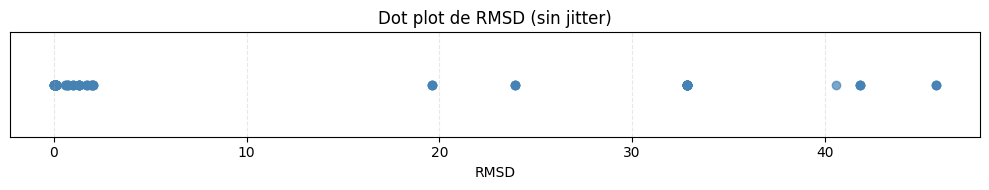

In [26]:
# Strip plot SIN jitter
plt.figure(figsize=(10, 2))
plt.scatter(df_ene['RMSD'], [0]*len(df_ene), color='steelblue', alpha=0.7)

plt.title('Dot plot de RMSD (sin jitter)')
plt.xlabel('RMSD')
plt.yticks([])  # Quitamos el eje Y, ya que no aporta información
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

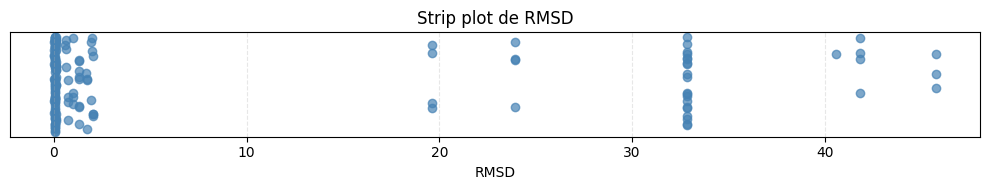

In [27]:
# Strip plot CON jitter

# Crear una pequeña "perturbación vertical" para que los puntos no se solapen visualmente
jitter = np.random.uniform(-0.02, 0.02, size=len(df_ene))

plt.figure(figsize=(10, 2))
plt.scatter(df_ene['RMSD'], jitter, color='steelblue', alpha=0.7)

plt.title('Strip plot de RMSD')
plt.xlabel('RMSD')
plt.yticks([])  # Quitamos el eje Y porque no tiene valor aquí
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Hay claramente 3 grupos de datos:
- RMSD = 0 (o muy cercano a 0)
- RMSD por encima de 0, pero inferior a 2
- RMSD por encima de 2

Nos centraremos ahora en los que son diferentes del primer modelo de SKEMPI que se usó en anteriores pipelines para evaluar la modelización de AlphaFold. Es decir, sólo el modelo 1 de SKEMPI vs. los demás.

In [39]:
df_ene_filtered = df_ene[df_ene["Name"].str.count("s")>0]
print(len(df_ene_filtered))
df_ene_filtered

84


,Ele,Desolv,VDW,Total,RMSD,Name
0,-31.320,-10.903,-163.937,-58.616,0.060,1A22_1_1__1A22_s_1
4,-31.320,-10.905,-163.937,-58.618,0.060,1A22_2_2__1A22_s_1
5,-31.320,-10.903,-163.937,-58.616,0.060,1A22_2_1__1A22_s_1
6,-26.832,-15.631,-126.855,-55.149,0.076,1BP3_1_1__1BP3_s_1
7,-28.947,18.962,-69.294,-16.914,0.089,1C1Y_s_1__1C1Y_1_1
...,...,...,...,...,...,...
152,-18.288,-14.588,-71.545,-40.031,0.074,4OFY_1_1__4OFY_s_1
154,-18.288,-14.588,-71.545,-40.031,1.958,4OFY_s_1__4OFY_s_3
155,-41.773,13.271,-119.304,-40.433,0.026,4RS1_1_1__4RS1_s_1
156,-9.346,-9.172,-109.105,-29.428,0.038,5F4E_s_1__5F4E_1_1


Graficamos los dos primeros grupos para poder ver bien su umbral de separación:

In [40]:
# 1. Filtrar el DataFrame según RMSD > 2

df_ene_cero = df_ene_filtered[df_ene_filtered['RMSD'] < 2]
df_ene_cero = df_ene_cero.sort_values('RMSD')
df_ene_cero.to_csv('resultados_RMSD_filtrados.csv')
df_ene_cero

,Ele,Desolv,VDW,Total,RMSD,Name
28,-7.600,-10.890,-113.713,-29.862,0.015,1E50_4_1__1E50_s_4
8,-2.004,-10.005,-102.319,-22.241,0.016,1E50_3_1__1E50_s_3
38,-5.017,5.537,-39.338,-3.413,0.019,1KNE_1_1__1KNE_s_1
37,-26.857,23.180,-50.332,-8.711,0.022,1K8R_s_1__1K8R_1_1
155,-41.773,13.271,-119.304,-40.433,0.026,4RS1_1_1__4RS1_s_1
...,...,...,...,...,...,...
147,-17.697,-15.358,-72.199,-40.275,1.702,4OFY_s_2__4OFY_s_3
140,-17.697,-15.358,-72.199,-40.275,1.702,4OFY_2_1__4OFY_s_3
151,-17.509,-13.299,-69.644,-37.773,1.933,4OFY_3_1__4OFY_s_1
149,-18.288,-14.588,-71.545,-40.031,1.958,4OFY_1_1__4OFY_s_3


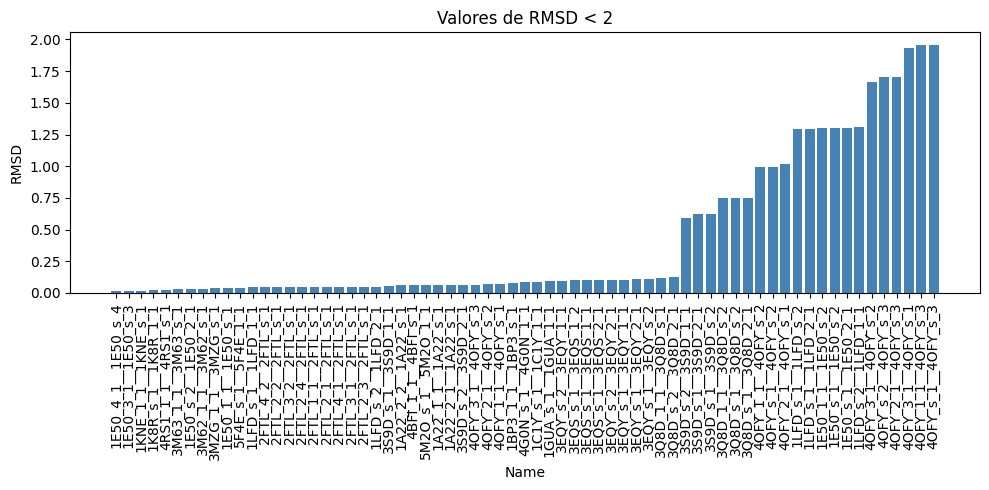

In [41]:
# Bar plot
x_labels = df_ene_cero['Name']
y_values = df_ene_cero['RMSD']

plt.figure(figsize=(10, 5))
plt.bar(x_labels, y_values, color='steelblue')

plt.title('Valores de RMSD < 2')
plt.ylabel('RMSD')
plt.xlabel('Name')
plt.xticks(rotation=45)
plt.xticks(rotation=90)  # Etiquetas verticales
plt.tight_layout()
plt.show()

Caramente están los que son menores de 0.25, que indica que son en esencia la misma estructura; y los que son mayores que 0.25, que son ligeramente diferentes entre sí y deberán mirarse atentamente en un visualizador estructural.  

En este segundo grupo se ve (también en el primero) que las coindicencias en el valor de RMSD se dan dentro de complejo. Por ejemplo:  3S9D_s_1__3S9D_s_2 y 3S9D_s_1__3S9D_2_1 tienen un RMSD de 0.622, lo que indica que 3S9D_s_2 (SKEMPI) y son 3S9D_2_1 (PDB) la misma estructura.

In [42]:
df_ene_A = df_ene_filtered[df_ene_filtered['RMSD'] < 0.25].sort_values('RMSD')
df_ene_B = df_ene_filtered[(df_ene_filtered['RMSD'] > 0.25) 
                           & (df_ene_filtered['RMSD'] < 3)].sort_values('RMSD')
df_ene_C = df_ene_filtered[df_ene_filtered['RMSD'] > 3].sort_values('RMSD')

In [46]:
df_ene_filtered["Complex"]=df_ene_filtered["Name"].str[0:4]

df2=df_ene_filtered[(df_ene_filtered["Name"].str.count("_3_")>0)]

/tmp/ipykernel_1252105/410623576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ene_filtered["Complex"]=df_ene_filtered["Name"].str[0:4]


In [48]:
df2[df2["Complex"]=="1E50"]

,Ele,Desolv,VDW,Total,RMSD,Name,Complex
8,-2.004,-10.005,-102.319,-22.241,0.016,1E50_3_1__1E50_s_3,1E50
9,-2.004,-10.005,-102.319,-22.241,2.017,1E50_s_3__1E50_s_4,1E50
11,-2.004,-10.005,-102.319,-22.241,45.760,1E50_3_1__1E50_s_2,1E50
16,-2.004,-10.005,-102.319,-22.241,45.760,1E50_s_3__1E50_2_1,1E50
30,-2.004,-10.005,-102.319,-22.241,2.017,1E50_3_1__1E50_s_4,1E50
35,-2.004,-10.005,-102.319,-22.241,19.605,1E50_3_1__1E50_s_1,1E50


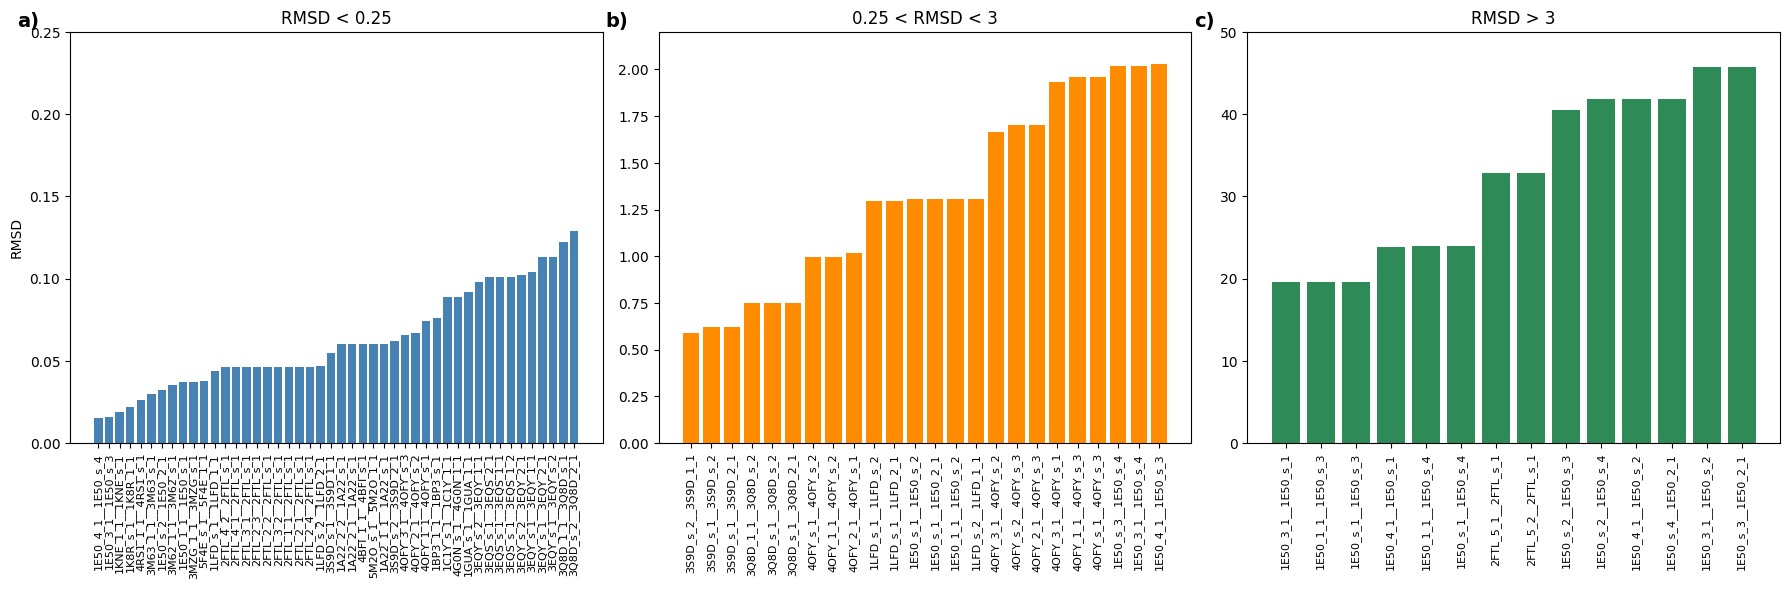

In [ ]:
# Crear figura con 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Letras para identificar cada subplot
labels = ['a)', 'b)', 'c)']

# --- Plot A ---
axs[0].bar(df_ene_A['Name'], df_ene_A['RMSD'], color='steelblue')
axs[0].set_title('RMSD < 0.25')
axs[0].set_ylabel('RMSD')
axs[0].set_ylim(0, 0.25)
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[0].text(-0.1, 1.05, labels[0], transform=axs[0].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')

# --- Plot B ---
axs[1].bar(df_ene_B['Name'], df_ene_B['RMSD'], color='darkorange')
axs[1].set_title('0.25 < RMSD < 3')
axs[1].set_ylim(0, 2.2)
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[1].text(-0.1, 1.05, labels[1], transform=axs[1].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')

# --- Plot C ---
axs[2].bar(df_ene_C['Name'], df_ene_C['RMSD'], color='seagreen')
axs[2].set_title('RMSD > 3')
axs[2].set_ylim(0, 50)
axs[2].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[2].text(-0.1, 1.05, labels[2], transform=axs[2].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left')

# Ajustar layout
fig.tight_layout()

# Guardar figura
fig.savefig('barplots_grupos_ABC_etiquetas.png', dpi=300, bbox_inches='tight')

# Mostrar figura
plt.show()

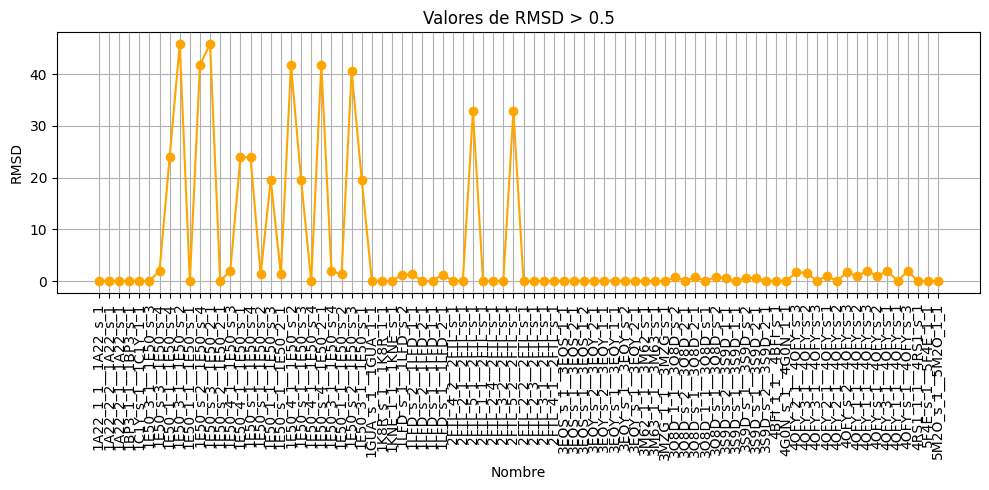

In [44]:
# Line plot de RMSD
import matplotlib.pyplot as plt

x_labels = df_ene_filtered['Name']
y_values = df_ene_filtered['RMSD']

plt.figure(figsize=(10, 5))
plt.plot(x_labels, y_values, marker='o', linestyle='-', color='orange')

plt.title('Valores de RMSD > 0.5')
plt.ylabel('RMSD')
plt.xlabel('Nombre')
plt.xticks(rotation=90)  # Nombres verticales para mejor lectura
plt.grid(True)
plt.tight_layout()
plt.show()
